<a href="https://colab.research.google.com/github/shamim-hussain/wine-quality-classification-logistic-regression/blob/main/Wine_Quality_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wine Quality Classification
We will classifiy wines into either "good" or "bad" categories based on different chemical properties. It makes sense to do logistic regression for this problem because the features (chemical properties) should have approximately a positive/negative lenear correlation with the quality. The dataset - 

Dataset Link: https://archive.ics.uci.edu/ml/datasets/wine+quality

It is moderate in size, which is ideal for logistic regression, because more complicated models may overfit the data. The quality is given as a rank, although we can turn it into a binary target, i.e., bad/good.

# Download and Process the Dataset

## Download
We will be using the "white wine" dataset.

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

--2021-09-10 03:43:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264426 (258K) [application/x-httpd-php]
Saving to: ‘winequality-white.csv’

winequality-white.c 100%[===================>] 258.23K  1.26MB/s    in 0.2s    

2021-09-10 03:43:32 (1.26 MB/s) - ‘winequality-white.csv’ saved [264426/264426]



## Open dataset

In [15]:
import pandas as pd

dataset = pd.read_csv('winequality-white.csv', sep=';')
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Let's check for missing data.

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


No missing data. We also wanna know the min, max, std of the columns

In [17]:
dataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


# Splitting the dataset into train and test.

We will do a 80/20 split for train and test

In [34]:
# Shuffle the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

trainset_len = int(len(dataset)*.8)
trainset = dataset.iloc[:trainset_len].reset_index(drop=True)
testset = dataset.iloc[trainset_len:].reset_index(drop=True)

# Separate features and target and binarize target
We will predict the quality, but since we wish to explore a binary classification problem. The 50-percentile is 6 so we will assign qualities as such -

**Bad:0** -> When quality between 0-5

**Good:1** -> When quality between 6-9

Also convert everything to float while at it.

In [36]:
train_features = trainset.drop('quality', axis=1).astype('float32')
train_targets = (trainset['quality'] > 5).astype('float32')

test_features = testset.drop('quality', axis=1).astype('float32')
test_targets = (testset['quality'] > 5).astype('float32')

# Standardizing input features

Let's have a look at the distributions of the training features.

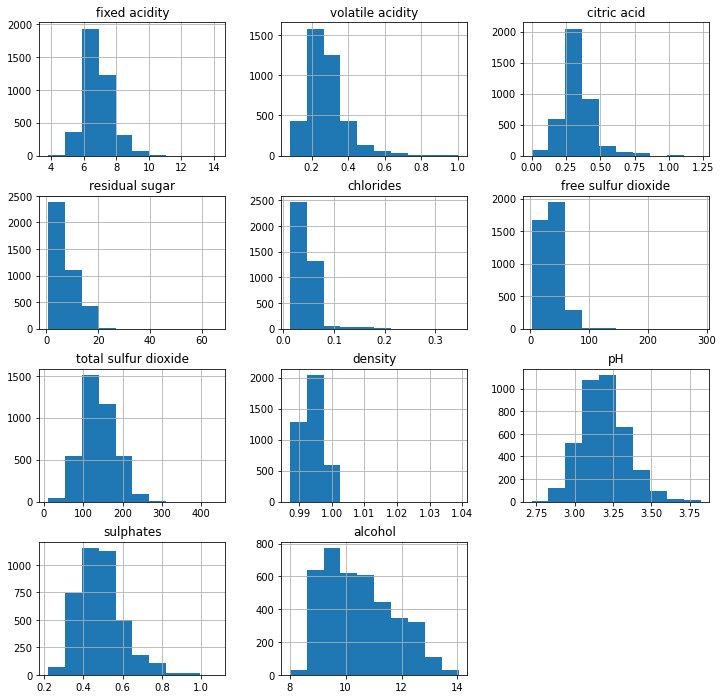

In [41]:
plots = train_features.hist(figsize=[12,12])

Very different distributions. So we standardize them before training.

In [42]:
feat_mean = train_features.mean()
feat_std = train_features.std()

train_features = (train_features - feat_mean)/feat_std
test_features = (test_features - feat_mean)/feat_std


Plot them again

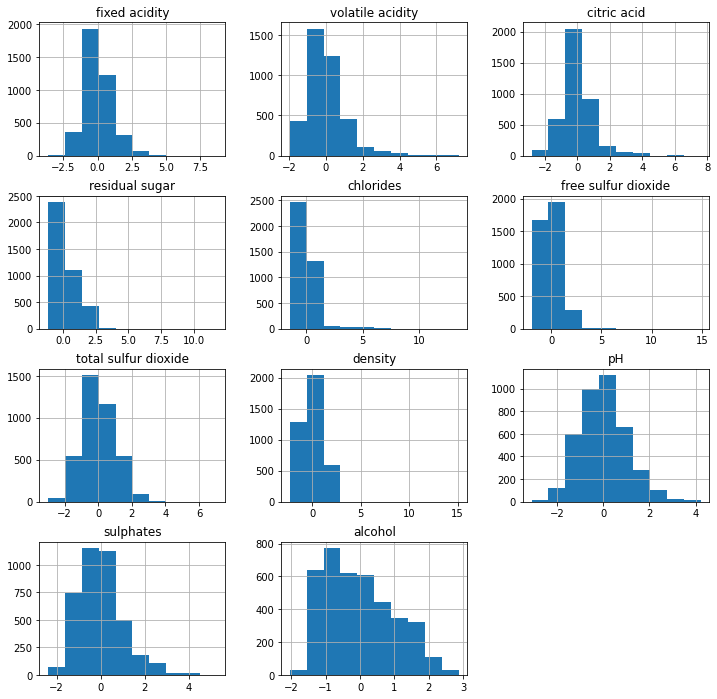

In [43]:
plots = train_features.hist(figsize=[12,12])

Looks better. Now to convert them to numpy arrays.

In [45]:
X_train = train_features.values
Y_train = train_targets.values

X_test = test_features.values
Y_test = test_targets.values

# Logistic Regression

Let us first write a function to calculate the loss and also the gradient of the loss.

In [85]:
import numpy as np

def sigmoid(x):
    return 1/(1+np.exp(-x))

def predict(w,b,X):
    return sigmoid(np.dot(X,w) + b)

def loss(Y,A,eps=1e-7):
    A_cliped = np.clip(A, eps, 1-eps)
    return -np.mean(Y * np.log(A) + (1-Y) * (np.log(1-A)))

def gradients(X,Y,A):
    dw = np.dot(X.T, A-Y)/X.shape[0]
    db = np.mean(A-Y)
    return dw, db

def accuracy(Y_true, Y_pred):
    return np.mean((Y_true==Y_pred).astype('float32'))


# Batch Gradient Descent

100%|██████████| 5000/5000 [00:01<00:00, 3294.92it/s]


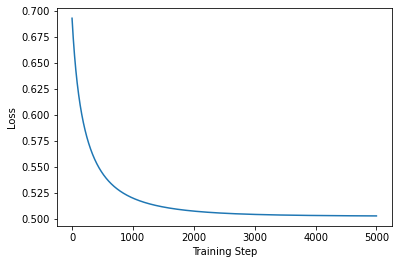

In [90]:
from tqdm import tqdm
import matplotlib.pyplot as plt


num_steps = 5000
learning_rate = 0.01

num_features = X_train.shape[1]
w = np.zeros((num_features,), dtype='float32')
b = np.array(0., dtype='float32')

loss_at_step = np.zeros((num_steps,),dtype='float32')
X = X_train
Y = Y_train
for step in tqdm(range(num_steps)):
    A = predict(w,b,X)
    loss_at_step[step] = loss(Y, A)
    dw, db = gradients(X,Y,A)
    w[()] = w - learning_rate*dw
    b = b - learning_rate*db

plt.figure()
plt.plot(loss_at_step)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.show()

## Results

In [91]:
print(f'Weights: {w}')
print(f'Bias: {b}')


Weights: [-0.06174603 -0.6427972   0.02835472  0.5877932   0.02887898  0.16200893
 -0.10275589 -0.35207963  0.0880068   0.15806429  1.0985469 ]
Bias: 0.888016828019169


In [92]:
acc_train = accuracy(Y_train, np.round(predict(w,b, X_train)))
acc_test = accuracy(Y_test, np.round(predict(w,b, X_test)))

print(f'Training accuracy = {acc_train:0.3%}')
print(f'Test accuracy = {acc_test:0.3%}')

Training accuracy = 75.523%
Test accuracy = 75.000%


# Mini-batch Gradient Descent

100%|██████████| 5000/5000 [00:01<00:00, 2979.40it/s]


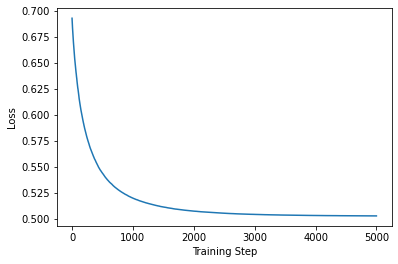

In [129]:
from tqdm import tqdm
import matplotlib.pyplot as plt


num_steps = 5000
batch_size = 64
learning_rate = 0.01

num_features = X_train.shape[1]
w = np.zeros((num_features,), dtype='float32')
b = np.array(0., dtype='float32')

loss_at_step = np.zeros((num_steps,),dtype='float32')


indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
batch_end = batch_size
for step in tqdm(range(num_steps)):
    batch_indices = indices[batch_end-batch_size:batch_end]
    X = X_train[batch_indices]
    Y = Y_train[batch_indices]

    loss_at_step[step] = loss(Y_train, predict(w,b,X_train))
    A = predict(w,b,X)
    dw, db = gradients(X,Y,A)
    w[()] = w - learning_rate*dw
    b = b - learning_rate*db

    batch_end += batch_size
    if batch_end > X_train.shape[0]:
        np.random.shuffle(indices)
        batch_end = batch_size


plt.figure()
plt.plot(loss_at_step)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.show()

## Results

In [130]:
print(f'Weights: {w}')
print(f'Bias: {b}')


Weights: [-0.06102977 -0.64183927  0.02755282  0.5873653   0.0293634   0.16099717
 -0.1039864  -0.35224828  0.08599368  0.15818633  1.0996914 ]
Bias: 0.8867037233710254


In [131]:
acc_train = accuracy(Y_train, np.round(predict(w,b, X_train)))
acc_test = accuracy(Y_test, np.round(predict(w,b, X_test)))

print(f'Training accuracy = {acc_train:0.3%}')
print(f'Test accuracy = {acc_test:0.3%}')

Training accuracy = 75.549%
Test accuracy = 74.898%


# RMSprop

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
100%|██████████| 5000/5000 [00:27<00:00, 182.74it/s]


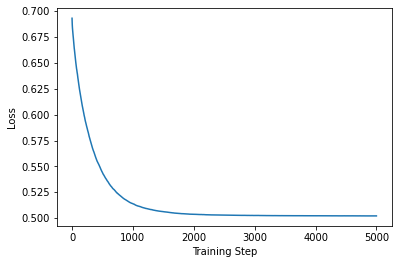

In [132]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

num_steps = 5000
batch_size = 64
learning_rate = 0.001

num_features = X_train.shape[1]
w_tf = tf.Variable(np.zeros((num_features,), dtype='float32'), trainable=True)
b_tf = tf.Variable(np.array(0., dtype='float32'), trainable=True)
w = w_tf.numpy()
b = b_tf.numpy()

loss_at_step = np.zeros((num_steps,),dtype='float32')

optim = RMSprop(lr = learning_rate)


indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
batch_end = batch_size
for step in tqdm(range(num_steps)):
    batch_indices = indices[batch_end-batch_size:batch_end]
    X = X_train[batch_indices]
    Y = Y_train[batch_indices]

    loss_at_step[step] = loss(Y_train, predict(w,b,X_train))
    A = predict(w,b,X)
    dw, db = gradients(X,Y,A)
    optim.apply_gradients([(dw,w_tf),(db,b_tf)])
    w = w_tf.numpy()
    b = b_tf.numpy()

    batch_end += batch_size
    if batch_end > X_train.shape[0]:
        np.random.shuffle(indices)
        batch_end = batch_size


plt.figure()
plt.plot(loss_at_step)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.show()

## Results

In [134]:
print(f'Weights: {w}')
print(f'Bias: {b}')


Weights: [-0.03935404 -0.6673208   0.02706496  0.6849011   0.05406864  0.1607932
 -0.08471413 -0.45301214  0.10347234  0.16733326  1.1085678 ]
Bias: 0.900698721408844


In [133]:
acc_train = accuracy(Y_train, np.round(predict(w,b, X_train)))
acc_test = accuracy(Y_test, np.round(predict(w,b, X_test)))

print(f'Training accuracy = {acc_train:0.3%}')
print(f'Test accuracy = {acc_test:0.3%}')

Training accuracy = 75.625%
Test accuracy = 74.898%


# Adam

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
100%|██████████| 5000/5000 [00:19<00:00, 253.76it/s]


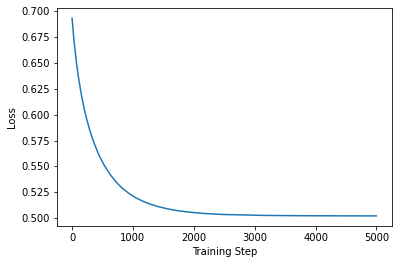

In [135]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

num_steps = 5000
batch_size = 64
learning_rate = 0.001

num_features = X_train.shape[1]
w_tf = tf.Variable(np.zeros((num_features,), dtype='float32'), trainable=True)
b_tf = tf.Variable(np.array(0., dtype='float32'), trainable=True)
w = w_tf.numpy()
b = b_tf.numpy()

loss_at_step = np.zeros((num_steps,),dtype='float32')

optim = Adam(lr = learning_rate)


indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
batch_end = batch_size
for step in tqdm(range(num_steps)):
    batch_indices = indices[batch_end-batch_size:batch_end]
    X = X_train[batch_indices]
    Y = Y_train[batch_indices]

    loss_at_step[step] = loss(Y_train, predict(w,b,X_train))
    A = predict(w,b,X)
    dw, db = gradients(X,Y,A)
    optim.apply_gradients([(dw,w_tf),(db,b_tf)])
    w = w_tf.numpy()
    b = b_tf.numpy()

    batch_end += batch_size
    if batch_end > X_train.shape[0]:
        np.random.shuffle(indices)
        batch_end = batch_size


plt.figure()
plt.plot(loss_at_step)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.show()

## Results

In [136]:
print(f'Weights: {w}')
print(f'Bias: {b}')


Weights: [-0.03232318 -0.65957415  0.02998926  0.69303614  0.05026429  0.14713328
 -0.08306552 -0.47857937  0.10887027  0.16551839  1.0887885 ]
Bias: 0.9017022252082825


In [137]:
acc_train = accuracy(Y_train, np.round(predict(w,b, X_train)))
acc_test = accuracy(Y_test, np.round(predict(w,b, X_test)))

print(f'Training accuracy = {acc_train:0.3%}')
print(f'Test accuracy = {acc_test:0.3%}')

Training accuracy = 75.600%
Test accuracy = 74.898%
